## Climate Data EDA and Preprocessing Notebook
- This notebook loads socio-economic and climate datasets for Nepal, performs preprocessing (including handling duplicates, missing values, and outliers), and saves a combined dataset.

### 1. Setup and Imports
- Import libraries.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

### 2. Load Socio-Economic Data
- Define a function to read CSV files using pathlib for path handling.

In [2]:
def read_csv(base_path: Path, filename: str):
    """
    Reads a CSV file from the given base_path and filename.

    Args:
        base_path (Path): Directory containing the file.
        filename (str): Name of the CSV file.

    Returns:
        pd.DataFrame: Loaded data.
    """
    file_path = base_path / filename
    return pd.read_csv(file_path)

# Set socio-economic data directory
socio_path = Path("data/raw/socio-economic/")
# Load the main dataset
data_1 = read_csv(socio_path, "eco-socio-env-health-edu-dev-energy_npl.csv")

# Display first rows
data_1.head()

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
0,Nepal,NPL,1983,Fertilizer consumption (% of fertilizer produc...,AG.CON.FERT.PT.ZS,129.065744
1,Nepal,NPL,2022,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,67.843176
2,Nepal,NPL,2021,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,112.610654
3,Nepal,NPL,2020,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,115.325540
4,Nepal,NPL,2019,Fertilizer consumption (kilograms per hectare ...,AG.CON.FERT.ZS,97.005587


### 3. Process Socio-Economic Indicators
- Select key indicators for further analysis.

In [3]:
# Map of indicators to simplified column names
selected_indicators = {
    'Agricultural land (sq. km)': 'agri_land_area',
    'Permanent cropland (% of land area)': 'cropland_pct',
    'Population density (people per sq. km of land area)': 'population_density',
    'Fertilizer consumption (kilograms per hectare of arable land)': 'fertilizer_kg_per_ha'
}

# Filter and reshape data
filtered = (
    data_1[data_1['Indicator Name'].isin(selected_indicators.keys())]
    .loc[:, ['Year', 'Indicator Name', 'Value']]
)

# Handle duplicate Year-Indicator pairs by averaging
filtered = (
    filtered
    .groupby(['Indicator Name', 'Year'], as_index=False)
    .agg(Value=('Value', 'mean'))
)

# Rename indicators and pivot to wide format
filtered['Indicator Name'] = filtered['Indicator Name'].map(selected_indicators)
socio_df = filtered.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()

# Impute missing values with median for each column
for col in socio_df.columns:
    if col != 'Year':
        socio_df.fillna({col: socio_df[col].median()}, inplace=True)

# Rename Year column to year
socio_df.rename(columns={'Year': 'year'}, inplace=True)

# Display processed socio-economic data
socio_df.head()

Indicator Name,year,agri_land_area,cropland_pct,fertilizer_kg_per_ha,population_density
0,1961,35530.0,0.174825,0.082503,72.156615
1,1962,35530.0,0.174825,0.238649,73.574238
2,1963,35630.0,0.174825,0.347467,75.033692
3,1964,35530.0,0.174825,0.565891,76.548196
4,1965,35530.0,0.174825,0.614064,78.135741


### 4. Load Climate Data
- Read multiple climate-related CSV files and combine into a single DataFrame.

In [4]:
climate_path = Path("data/raw/climate/")

# Dictionary of climate files and target column names
climate_files = {
    "observed-annual-average_temp.csv": "avg_mean_temp",
    "observed-annual-average-min-temp.csv": "avg_min_temp",
    "observed-annual-average-max-temp.csv": "avg_max_temp",
    "observed-annual-relative-humidity.csv": "relative_humidity",
    "observed_annual-average-largest-1-day-precipitation.csv": "precipitation_max"
}

# Load each file and rename columns
climate_dfs = {}
for fname, col in climate_files.items():
    df = read_csv(climate_path, fname)
    # Assume 'Category' is the year index and 'Annual Mean' is the value
    climate_dfs[col] = df.set_index('Category')['Annual Mean']

# Combine into one DataFrame
climate_data = pd.DataFrame(climate_dfs).reset_index().rename(columns={'Category': 'year'})

# Display climate data
climate_data.head()


,year,avg_mean_temp,avg_min_temp,avg_max_temp,relative_humidity,precipitation_max
0,1950,11.24,6.66,15.71,74.93,88.27
1,1951,11.21,6.53,15.84,74.99,91.14
2,1952,10.84,6.42,15.23,78.17,74.80
3,1953,10.90,6.42,15.38,77.45,102.32
4,1954,11.48,6.71,16.24,70.61,125.67


### 4.1 Rainfall Data
- Load and aggregate daily rainfall to annual mean.

In [5]:
rainfall = read_csv(climate_path, "npl-rainfall-adm2-full.csv")

# Drop header row if duplicated and convert types
rainfall = rainfall.drop(index=0)
rainfall['date'] = pd.to_datetime(rainfall['date'])
rainfall['rfh'] = pd.to_numeric(rainfall['rfh'], errors='coerce')

# Compute annual mean rainfall
rainfall['year'] = rainfall['date'].dt.year
annual_rain = rainfall.groupby('year')['rfh'].mean().reset_index(name='annual_rainfall')

# Merge with climate_data
climate_data = climate_data.merge(annual_rain, on='year', how='outer')

# Impute missing climate values with column mean
climate_data.fillna(climate_data.mean(numeric_only=True), inplace=True)

# Display combined climate data
climate_data.head()

C:\Users\SkullCandy\AppData\Local\Temp\ipykernel_7576\3810117432.py:13: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


,year,avg_mean_temp,avg_min_temp,avg_max_temp,relative_humidity,precipitation_max,annual_rainfall
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567


### 5. Merge Socio-Economic and Climate Data

In [10]:
combined_df = pd.merge(climate_data, socio_df, on='year', how='outer')
# Final imputation of any remaining missing values
combined_df.fillna(combined_df.mean(numeric_only=True), inplace=True)

combined_df.head()




,year,avg_mean_temp,avg_min_temp,avg_max_temp,relative_humidity,precipitation_max,annual_rainfall,agri_land_area,cropland_pct,fertilizer_kg_per_ha,population_density
0,1950,11.24,6.66,15.71,74.93,88.27,41.292567,40334.66129,0.537348,27.372378,141.571356
1,1951,11.21,6.53,15.84,74.99,91.14,41.292567,40334.66129,0.537348,27.372378,141.571356
2,1952,10.84,6.42,15.23,78.17,74.80,41.292567,40334.66129,0.537348,27.372378,141.571356
3,1953,10.90,6.42,15.38,77.45,102.32,41.292567,40334.66129,0.537348,27.372378,141.571356
4,1954,11.48,6.71,16.24,70.61,125.67,41.292567,40334.66129,0.537348,27.372378,141.571356


In [14]:
# Final check for missing values
print(combined_df.isnull().sum())

year                    0
avg_mean_temp           0
avg_min_temp            0
avg_max_temp            0
relative_humidity       0
precipitation_max       0
annual_rainfall         0
agri_land_area          0
cropland_pct            0
fertilizer_kg_per_ha    0
population_density      0
dtype: int64


### 6. Exploratory Data Analysis: Outlier Detection and Capping
- Using IQR method to cap outliers across numerical features.

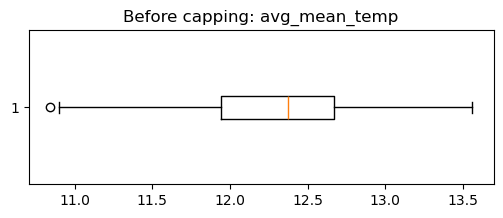

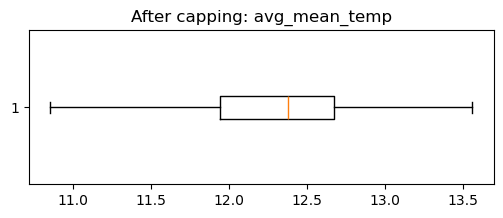

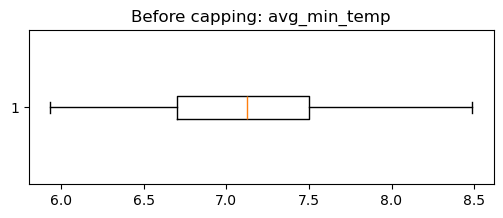

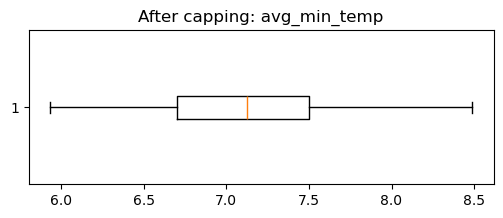

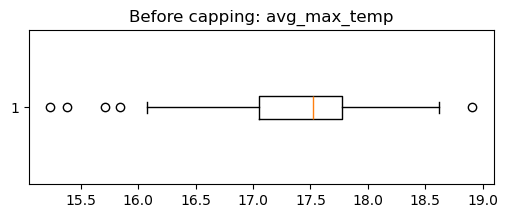

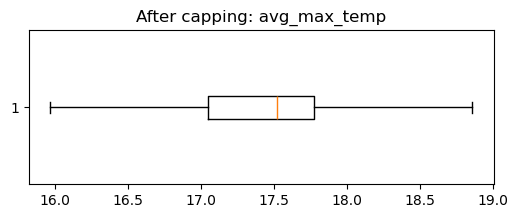

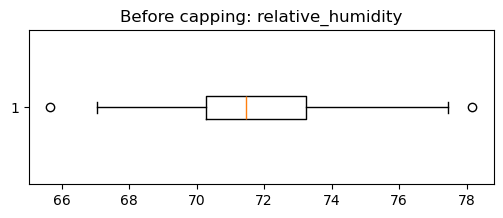

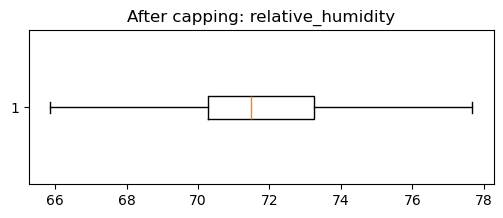

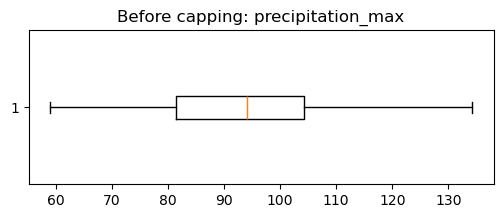

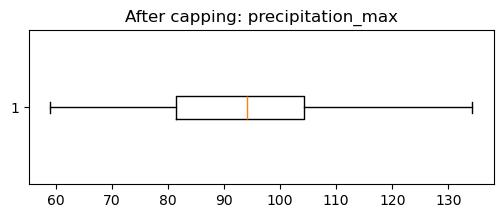

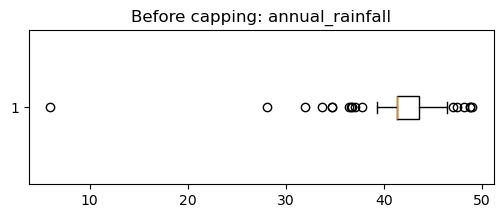

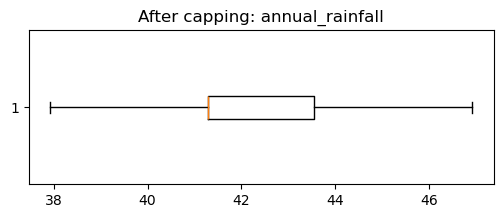

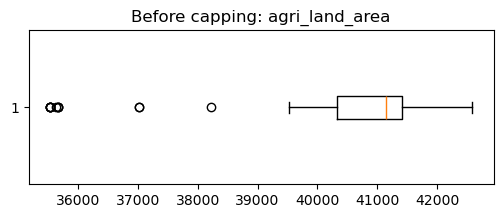

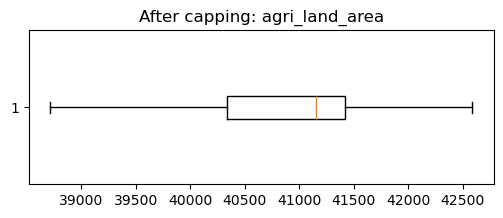

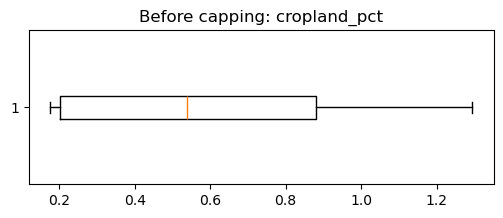

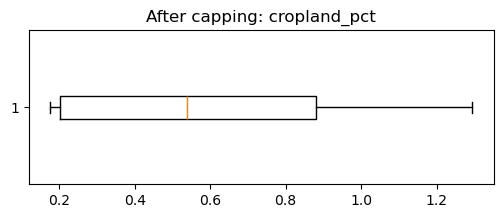

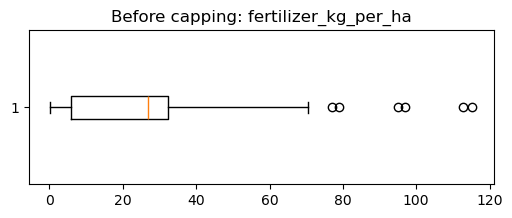

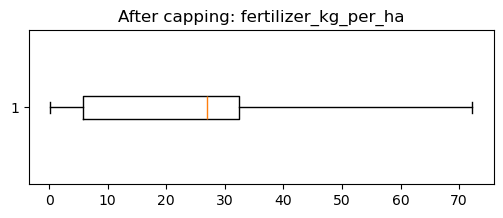

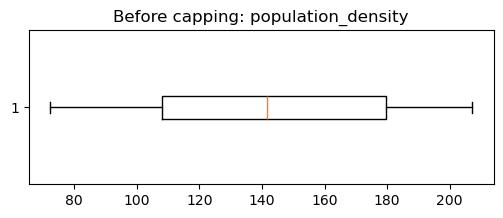

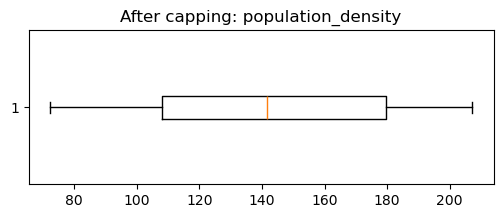

In [7]:
num_cols = combined_df.select_dtypes(include=[np.number]).columns.drop('year')

# Function to cap outliers based on IQR
# %%
def cap_outliers(series: pd.Series) -> pd.Series:
    """
    Caps values in a Series at 1.5 * IQR from Q1 and Q3.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series.clip(lower, upper)

# Apply capping and visualize before/after
for col in num_cols:
    # Plot before capping
    plt.figure(figsize=(6, 2))
    plt.boxplot(combined_df[col].dropna(), vert=False)
    plt.title(f"Before capping: {col}")
    plt.show()

    # Cap outliers
    combined_df[col] = cap_outliers(combined_df[col])

    # Plot after capping
    plt.figure(figsize=(6, 2))
    plt.boxplot(combined_df[col].dropna(), vert=False)
    plt.title(f"After capping: {col}")
    plt.show()

# ## 7. Save Processed Data

In [15]:
output_path = Path("data/processed_data")
output_path.mkdir(parents=True, exist_ok=True)
combined_df.to_csv(output_path / "combined_data.csv", index=False)

print("Processed data saved to:", output_path / "combined_data.csv")

Processed data saved to: data\processed_data\combined_data.csv
